# Intro

The [ASL Alphabet](https://www.kaggle.com/grassknoted/asl-alphabet) data set provides 87,000 images of the ASL alphabet. This notebook aims to take a first step at building a model around that data that is sufficiently versatile to handle images of the ASL alphabet with different hands and different backgrounds. This project is part of an assignment for the W207 Applied Machine Learning class in the UC Berkeley MIDS (Master of Information and Data Science) program.

# The data

There are 2 data sets utilized in this notebook:

1. [ASL Alphabet](https://www.kaggle.com/grassknoted/asl-alphabet) - This data set is the basis for the model.
2. [ASL Alphabet Test](https://www.kaggle.com/danrasband/asl-alphabet-test/home) - This data set was made specifically for validating the model created using the above data set, and is intended to be used to improve the feature engineering and modeling process to make it more versatile in "the wild" with less contrived images.

### Import Libraries

In [34]:
# Imports for Deep Learning
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator

# Ensure consistency across runs
from numpy.random import seed
import random
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

# Imports to view data
import cv2
from glob import glob

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
from keras.utils import print_summary
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Utils
from pathlib import Path
import pandas as pd
import numpy as np
from os import getenv
import time
import itertools

# Image Preprocessing
from skimage.filters import sobel, scharr

### Set Up Global Variables

The following variables will be used throughout. The `MODEL_` variables are helpful for iterating over the notebook without re-fitting the model all the time, but aren't useful in Kaggle.

In [35]:
# Set global variables
TRAIN_DIR = '../Dataset/asl_alphabet_train/asl_alphabet_train'
TEST_DIR = '../Dataset/asl_alphabet_test/asl_alphabet_test'
CUSTOM_TEST_DIR = '../Dataset/asl_alphabet_test/asl_alphabet_test'
CLASSES = [folder[len(TRAIN_DIR) + 1:] for folder in glob(TRAIN_DIR + '/*')]
CLASSES.sort()

TARGET_SIZE = (64, 64)
TARGET_DIMS = (64, 64, 3) # add channel for RGB
N_CLASSES = 29
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 64

# Model saving for easier local iterations
MODEL_DIR = 'aslalphabetcnnmodel1'
MODEL_PATH = MODEL_DIR + '/cnn-model.h5'
MODEL_WEIGHTS_PATH = MODEL_DIR + '/cnn-model.weights.h5'
MODEL_SAVE_TO_DISK = getenv('KAGGLE_WORKING_DIR') != '/kaggle/working'

print('Save model to disk? {}'.format('Yes' if MODEL_SAVE_TO_DISK else 'No'))

Save model to disk? Yes


### Sample Images

The following shows one example of each image class:

In [36]:
def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CLASSES) / cols))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(CLASSES)):
        cls = CLASSES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

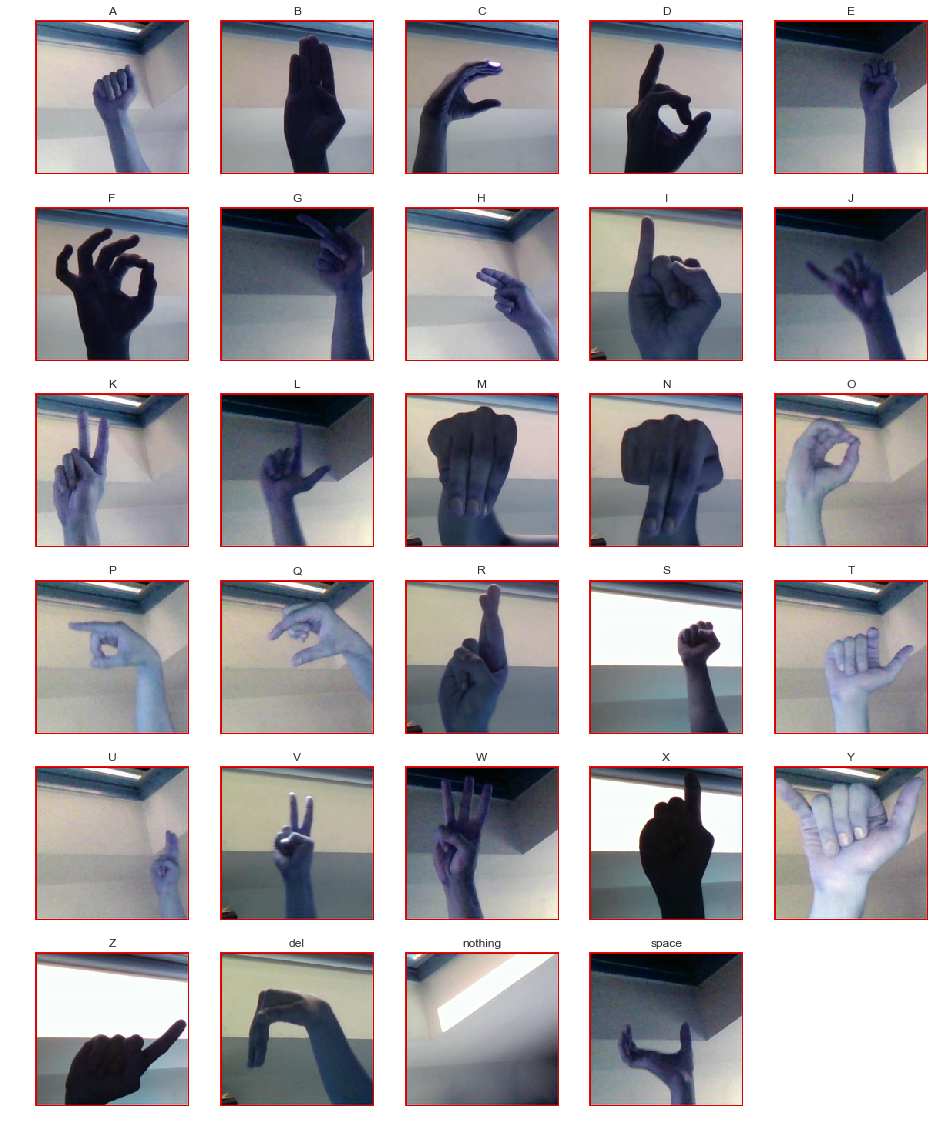

In [37]:
plot_one_sample_of_each(TRAIN_DIR)

And the following is a random sampling of the "real-world" test set:

In [39]:
plot_one_sample_of_each(CUSTOM_TEST_DIR)

ValueError: Sample larger than population or is negative

<Figure size 1152x1440 with 0 Axes>

## Data Processing Set-Up

In the next snippet, I make a generator for use by Keras. The `make_generator` function is versatile enough to be used for setting up a generator for training, validation, prediction, and testing.

In [40]:
def preprocess_image(image):
    '''Function that will be implied on each input. The function
    will run after the image is resized and augmented.
    The function should take one argument: one image (Numpy tensor
    with rank 3), and should output a Numpy tensor with the same
    shape.'''
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    return sobely

def make_generator(options):
    '''Creates two generators for dividing and preprocessing data.'''
    validation_split = options.get('validation_split', 0.0)
    preprocessor = options.get('preprocessor', None)
    data_dir = options.get('data_dir', TRAIN_DIR)

    augmentor_options = {
        'samplewise_center': True,
        'samplewise_std_normalization': True,
    }
    if validation_split is not None:
        augmentor_options['validation_split'] = validation_split
    
    if preprocessor is not None:
        augmentor_options['preprocessing_function'] = preprocessor
    
    flow_options = {
        'target_size': TARGET_SIZE,
        'batch_size': BATCH_SIZE,
        'shuffle': options.get('shuffle', None),
        'subset': options.get('subset', None),
    }

    data_augmentor = ImageDataGenerator(**augmentor_options)
    return data_augmentor.flow_from_directory(data_dir, **flow_options)

## Model Specification

The model used here is taken from a [Kaggle kernel called Running Kaggle Kernels with a GPU](https://www.kaggle.com/grassknoted/asl-alphabet), and is an example of a convolutional neural network. It is made up of 12 layers, as is diagrammed below.

In [41]:
def load_model_from_disk():
    '''A convenience method for re-running certain parts of the
    analysis locally without refitting all the data.'''
    model_file = Path(MODEL_PATH)
    model_weights_file = Path(MODEL_WEIGHTS_PATH)
                      
    if model_file.is_file() and model_weights_file.is_file():
        print('Retrieving model from disk...')
        model = load_model(model_file.__str__())
                      
        print('Loading CNN model weights from disk...')
        model.load_weights(model_weights_file)
        return model
    
    return None

CNN_MODEL = load_model_from_disk()
REPROCESS_MODEL = (CNN_MODEL is None)

print('Need to reprocess? {}'.format(REPROCESS_MODEL))

Need to reprocess? True


In [42]:
def build_model(save=False):
    print('Building model afresh...')
    
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=TARGET_DIMS))
    model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    if save: model.save(MODEL_PATH)
        
    return model

if REPROCESS_MODEL:
    CNN_MODEL = build_model(save=MODEL_SAVE_TO_DISK)

print_summary(CNN_MODEL)

Building model afresh...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 61, 61, 64)        3136      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 29, 29, 64)        65600     
_________________________________________________________________
dropout_7 (Dropout)          (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 128)       131200    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 128)       262272    
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 9, 9, 256)     

## Model Fitting

Here we fit the model using the 87,000 images: 78,300 (90% of the data) for training and 8,700 (the remaining 10%) for validation.

In [44]:
def make_generator_for(subset):
    '''Create a generator for the training or validation set.'''
    generator_options = dict(
        validation_split=VALIDATION_SPLIT,
        shuffle=True,
        subset=subset,
        preprocessor=preprocess_image,
    )
    return make_generator(generator_options)


def fit_model(model, train_generator, val_generator, save=False):
    '''Fit the model with the training and validation generators.'''    
    history = model.fit_generator(train_generator, epochs=5, validation_data=val_generator, steps_per_epoch=train_generator.__len__(), validation_steps=val_generator.__len__())
    
    if save: model.save_weights(MODEL_WEIGHTS_PATH)
    
    return history


CNN_TRAIN_GENERATOR = make_generator_for('training')
CNN_VAL_GENERATOR = make_generator_for('validation')

HISTORY = None
if REPROCESS_MODEL:
    start_time = time.time()
    HISTORY = fit_model(CNN_MODEL, CNN_TRAIN_GENERATOR, CNN_VAL_GENERATOR, save=MODEL_SAVE_TO_DISK)
    print('Fitting the model took ~{:.0f} second(s).'.format(time.time() - start_time))


columns=['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']
pd.DataFrame(data=[x.shape for x in CNN_MODEL.weights], columns=columns)

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Epoch 1/5


ImportError: Could not import PIL.Image. The use of `array_to_img` requires PIL.

In [ ]:
if HISTORY:
    print('Final Accuracy: {:.2f}%'.format(HISTORY.history['acc'][4] * 100))
    print('Validation set accuracy: {:.2f}%'.format(HISTORY.history['val_acc'][4] * 100))

### Validation Against Real-World Data

The data provided in the ASL Alphabet data set is very much contrived. It's obvious that the images are made with one person's hand, in basically one environment. Because if this, it seemed like a good idea to validate that the models were not overfitting to images in this controlled environment. Below you can see a video compilation of all the "A" images.

In [ ]:
%%HTML
<div align="middle">
    <video width="80%" controls>
        <source src="https://s3-us-west-2.amazonaws.com/danrasband-w207/A.mp4" type="video/mp4">
    </video>
</div>

Below is an attempt to evaluate our model against the ASL Alphabet Test data set, which is more like a real-world data set.

First, here are some helper methods for plotting the confusion matrices:

In [ ]:
def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    '''
    Plot a confusion matrix heatmap using matplotlib. This code was obtained from
    the scikit-learn documentation:

    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(16, 16))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

In [ ]:
def evaluate_model(generator):
    start_time = time.time()
    evaluations = CNN_MODEL.evaluate_generator(generator)
    for i in range(len(CNN_MODEL.metrics_names)):
        print("{}: {:.2f}%".format(
            CNN_MODEL.metrics_names[i], evaluations[i] * 100))
    print('Took {:.0f} seconds to evaluate this set.'.format(
        time.time() - start_time))

    start_time = time.time()
    predictions = CNN_MODEL.predict_generator(generator)
    print('Took {:.0f} seconds to get predictions on this set.'.format(
        time.time() - start_time))

    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    return dict(y_pred=y_pred, y_true=y_true)


def evaluate_validation_dataset():
    gen_options = dict(
        validation_split=0.1,
        data_dir=TRAIN_DIR,
        shuffle=False,
        subset='validation',
        preprocessor=preprocess_image,
    )
    val_gen = make_generator(gen_options)
    return evaluate_model(val_gen)


def evaluate_test_dataset():
    gen_options = dict(
        validation_split=0.0,
        data_dir=CUSTOM_TEST_DIR,
        shuffle=False,
        preprocessor=preprocess_image,
    )
    test_gen = make_generator(gen_options)
    return evaluate_model(test_gen)

### Re-evaluate the Validation Set

Here I run an evaluation against a non-shuffled validation set to once again check performance and see how bad things get confused:

In [ ]:
CNN_VALIDATION_SET_EVAL = evaluate_validation_dataset()

You can see below that most predictions go pretty well, but there are some issues present:

In [ ]:
print(classification_report(**CNN_VALIDATION_SET_EVAL, target_names=CLASSES))

In [ ]:
with sns.axes_style('ticks'):
    plot_confusion_matrix_with_default_options(**CNN_VALIDATION_SET_EVAL, classes=CLASSES)

Now, looking at the ASL Alphabet Test data set, we can see that our initial model is still too tightly fitted to the original data set:

In [ ]:
CNN_TEST_SET_EVAL = evaluate_test_dataset()

In [ ]:
print(classification_report(**CNN_TEST_SET_EVAL, target_names=CLASSES))

In [ ]:
with sns.axes_style('ticks'):
    plot_confusion_matrix_with_default_options(**CNN_TEST_SET_EVAL, classes=CLASSES)

### Conclusion

While the convolutional neural network used here does in fact provide a strong predictor for the ASL Alphabet data set, it doesn't work quite as well in more "real-world" environments. Further work is required to determine better preprocessing techniques or to experiment with different neural network setups.

### Next Steps

The most logical next step for this project is to experiment with preprocessing techniques. An interesting idea is to use [Mask R-CNNs](https://arxiv.org/abs/1703.06870) to find the hand in the image and basically crop, resize, and resample the image to pull out that part of the image and leave out the background and other interference. There are projects, such as [matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN), that are worth exploring.